In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.dpi'] = 150
import glob, os

import scipy.stats as st
import timeit
from sklearn.decomposition import PCA

# Regress viral severity on predictors

(severity) ~ (# of human targets) + (# of papers studying the virus) + (size of viral genomes) + more predictors.

In [218]:
# also rearranged so that all Homo sapiens is in the right column
virus_human = pd.read_csv("../Processed/virus_human.csv")

# don't need virus_virus, which is a dataframe of viral proteins interacting with each other

proteins = pd.read_csv("../Processed/enriched_GO_proteins.csv")

In [219]:
# check that all human proteins are in the second column
print(virus_human['Taxname B'].unique(), virus_human['Taxid B'].unique())

# human should not be in the first column
print('Homo sapiens' in virus_human['Taxname A'].values)
print(9606 in virus_human['Taxid A'].values)

['Homo sapiens'] [9606]
False
False


In [220]:
print(len(virus_human["Taxname A"].unique()), "viral species in the PPI dataset")

181 viral species in the PPI dataset


In [221]:
print(len(virus_human["Taxid A"].unique()), "viral taxa in the PPI dataset")

181 viral taxa in the PPI dataset


In [222]:
# save taxids to a text file to search with Taxonomizr in R (code below)
virus_human[["Taxid A"]].drop_duplicates().to_csv("viral_taxids.txt", index=False, sep="\t")

# Get taxonomic ranks using `Taxonomizr` in R

## Easiest way to collapse groups of viruses (i.e. different papillomaviruses will also have the same genus)

https://cran.r-project.org/web/packages/taxonomizr/vignettes/usage.html

```r
install.packages("taxonomizr")
library(taxonomizr)

prepareDatabase('accessionTaxa.sql')

df <- read.table("viral_taxids.txt", stringsAsFactors=FALSE, quote="", header=TRUE, sep="\t")

taxids <- df[["Taxid.A"]]

# get taxonomies for the taxids
taxa <- getTaxonomy(taxids,'accessionTaxa.sql')

# save taxa to a new dataframe
write.csv(taxa, "viral_taxonomies.csv")
```

In [223]:
# viral_taxonomies = pd.read_csv("viral_taxonomies.csv")
# viral_taxonomies.rename(columns={viral_taxonomies.columns[0]: 'Taxid A'}, inplace=True)

# # combine the taxonomies with the original dataframe
# virus_human = pd.merge(virus_human, viral_taxonomies, on='Taxid A')
# virus_human.to_csv("../Processed/virus_human.csv", index=False)

# Get genome sizes of all the viruses

https://www.ncbi.nlm.nih.gov/genome/browse/#!/viruses/

Use taxonomizr to get the exact species name, rather than the strain name (which is what's associated with the taxids).

This species name should be easier to search than the taxid-associated taxname.

In [224]:
virus_genome_sizes = pd.read_csv("../Data/virus_genome_sizes.csv")

In [225]:
# ~1/2 as many species as taxids
print(len(virus_human.species.unique()))

# make a dictionary to map between them
taxnames_species_dict = dict(zip(virus_human["Taxname A"], virus_human["species"]))

86


In [226]:
# this only has 62 of the 83 species in the dataframe. Compare families for the rest because the Organism Groups column contains them
found_viruses_df = virus_genome_sizes.loc[virus_genome_sizes["#Organism Name"].isin(virus_human['species'].unique())].drop_duplicates(["#Organism Name", "Size(Mb)"])

found_viruses = found_viruses_df["#Organism Name"].unique()

print(len(found_viruses), "viruses found in the database")

missing_viruses = list(set(virus_human['species'].unique()) - set(found_viruses))

print(len(missing_viruses), "viruses not a direct match")

62 viruses found in the database
24 viruses not a direct match


In [227]:
virus_genomes_df = pd.DataFrame(found_viruses_df.groupby("#Organism Name")["Size(Mb)"].mean()).reset_index()
virus_genomes_df.columns = ["Species", "Size(Mb)"]

add_viruses_to_df = []
genome_sizes = []

for virus in missing_viruses:
    
    res_df = virus_genome_sizes.loc[virus_genome_sizes["#Organism Name"].str.contains("|".join(virus.split(" ")), case=False)]
    if len(res_df) > 0:
        genome_sizes.append(res_df["Size(Mb)"].mean())
        add_viruses_to_df.append(virus)
    else:
        print(virus)
        
# add rubella virus manually because it's just 1 virus
add_viruses_to_df.append("Rubivirus rubellae")
genome_sizes.append(virus_genome_sizes.loc[virus_genome_sizes["#Organism Name"].str.contains("rubella", case=False)]["Size(Mb)"].mean())

virus_genomes_df = pd.concat([virus_genomes_df, pd.DataFrame({"Species": add_viruses_to_df, "Size(Mb)": genome_sizes})]).reset_index(drop=True)

assert len(set(virus_genomes_df["Species"]).intersection(virus_human["species"])) == len(virus_genomes_df)

Rubivirus rubellae


In [273]:
model_df = pd.DataFrame(taxnames_species_dict, index=[0]).T.reset_index()
model_df.columns = ["Taxname", "Species"]

# combine with the genome lengths
model_df = pd.merge(model_df, virus_genomes_df, on="Species", how="outer")

# number of proteins interacting with human proteins for a given viral species
protein_interactions = pd.DataFrame(virus_human.groupby(["Taxname A"])["Protein A"].apply(lambda x: len(np.unique(x)))).reset_index()
protein_interactions.columns = ["Taxname", "num_unique_interactions"]

# combine with the protein_interactions list
model_df = pd.merge(model_df, protein_interactions, on="Taxname", how="outer")

publications_df = pd.DataFrame(virus_human.groupby(["Taxname A"])["Publication"].apply(lambda x: len(np.unique(x)))).reset_index()
publications_df.columns = ["Taxname", "num_publications"]

# combine with the publications list
model_df = pd.merge(model_df, publications_df, on="Taxname", how="outer")

# finally, save it to a dataframe for modeling later (need the outcome variable)
model_df.to_csv("model_predictors.csv", index=False)

# Use fatality rate for viral severity? And # of infections worldwide?

In [274]:
model_df = pd.read_csv("model_predictors.csv")

In [277]:
# might be the biggest predictor. Spearman rho totally not significant for num_interactions and genome size
st.spearmanr(model_df["num_unique_interactions"], model_df["num_publications"])

SpearmanrResult(correlation=0.8107071469106947, pvalue=1.7608737202462508e-43)

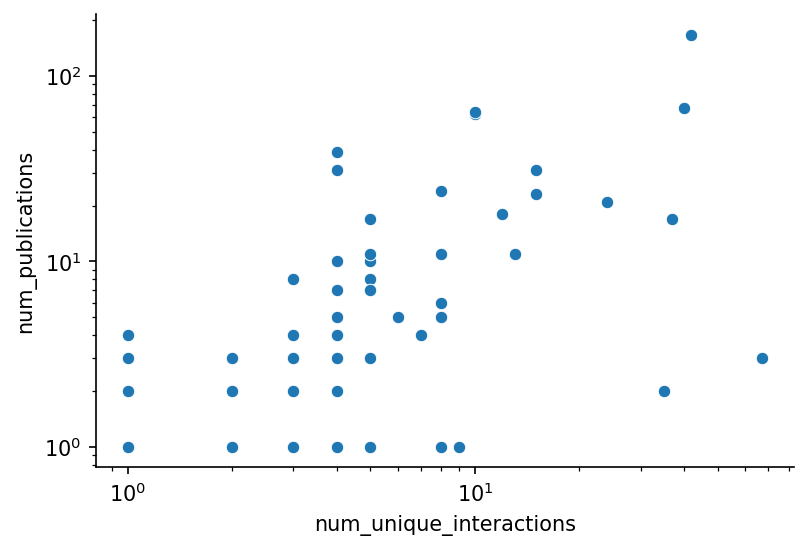

In [279]:
sns.scatterplot(data=model_df, x="num_unique_interactions", y="num_publications")
plt.xscale("log")
plt.yscale("log")
sns.despine()

# Curate tropism, respiratory vs. GI vs. immune vs. other, latent vs. nonlatent infection

# Could be more interesting predictor OR outcome variables!

predictor ~ severity + tropism + publications + 

["respiratory"]*7 + ["neurological"] + ["respiratory"]*16 + ["neurological"] + ["gastrointestinal"] + ["respiratory"]*3

In [216]:
["respiratory"]*7 + ["neurological"] + ["respiratory"]*16 + ["neurological"] + ["gastrointestinal"] + ["respiratory"]*3

['respiratory',
 'respiratory',
 'respiratory',
 'respiratory',
 'respiratory',
 'respiratory',
 'respiratory',
 'neurological',
 'respiratory',
 'respiratory',
 'respiratory',
 'respiratory',
 'respiratory',
 'respiratory',
 'respiratory',
 'respiratory',
 'respiratory',
 'respiratory',
 'respiratory',
 'respiratory',
 'respiratory',
 'respiratory',
 'respiratory',
 'respiratory',
 'neurological',
 'gastrointestinal',
 'respiratory',
 'respiratory',
 'respiratory']

<b>Maybe see where they're located in PFAM domain space (no dimensionality reduction, just compute Euclidean distance in however many dimensions there are).</b>

<b>Could build a phylogenetic tree and pick viruses that share a common ancestor within some distance. Then use sequences of the homologous proteins as inputs to a model.</b>

In [360]:
# how many human proteins does each virus interact with? 
human_proteins_per_virus = pd.DataFrame(virus_human.groupby(["Taxname A", "Protein B"])["Protein A"].apply(lambda x: len(np.unique(x)))).reset_index()
human_proteins_per_virus.columns = ["viral_species", "human_uniprot", "counts"]

# convert to matrix
data = human_proteins_per_virus.pivot(index="viral_species", columns="human_uniprot", values="counts").fillna(0)

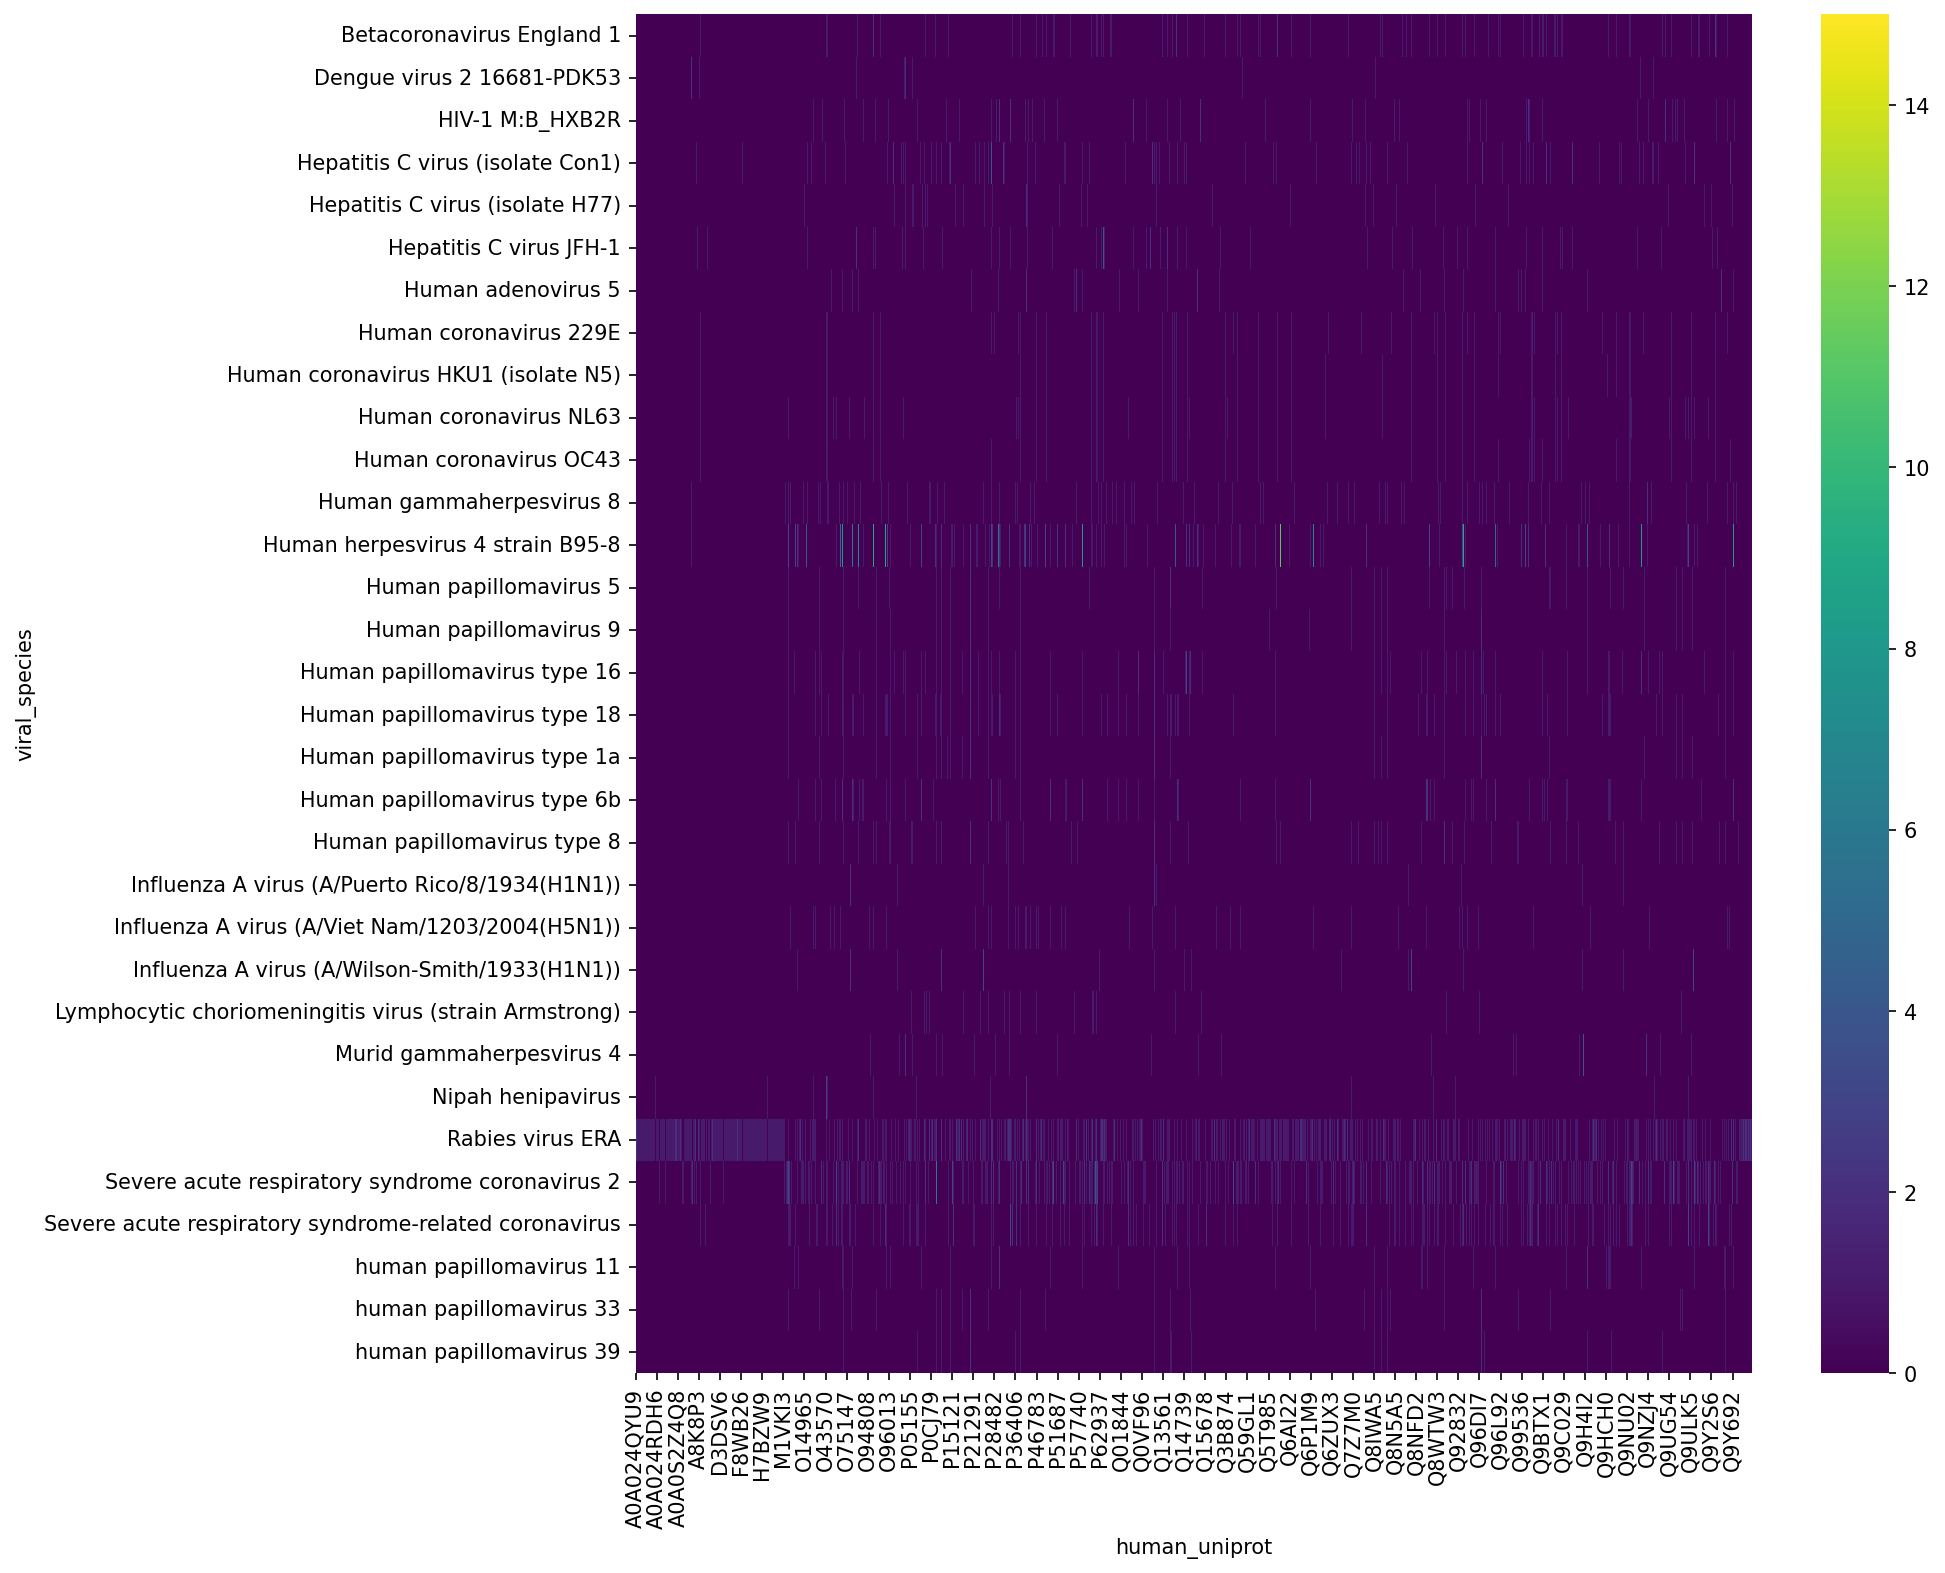

In [359]:
plt.figure(figsize=(12, 12))
sns.heatmap(data.loc[data.index[(data.sum(axis=1) > 100).values], :], cmap="viridis")
plt.show()

### Epstein-Barr virus has the most documented interactions with human proteins

### Maybe point out that it's surprising that Nipah made it to the list, given that it's so rare

That one paper found ~60-70 interactions

In [299]:
pca = PCA(10).fit(data)

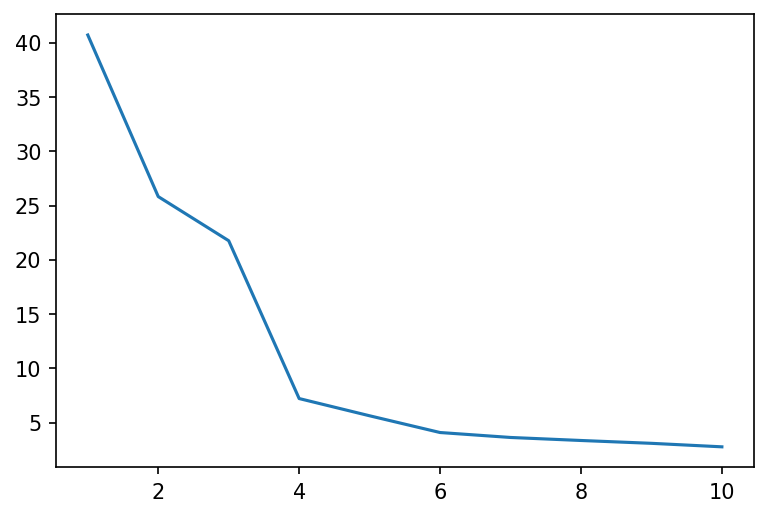

In [ ]:
plt.plot(np.arange(1, 11), pca.explained_variance_)

In [305]:
pca_2 = PCA(6)
pca_2.fit(data.values)

pca_transformed = pca_2.transform(data.values)

In [308]:
pc1, pc2, _, _, _, _ = list(zip(*pca_transformed))

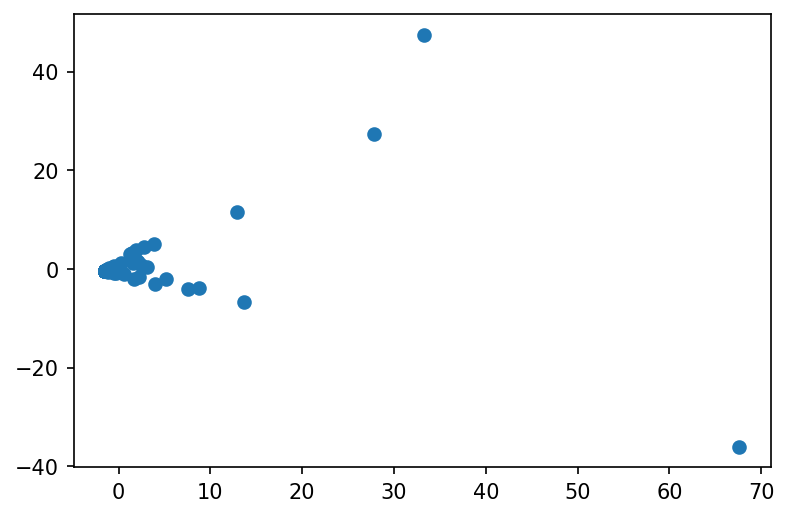

In [309]:
plt.scatter(pc1, pc2)